# Character Segmentation using Char Classifier
This is experimental solution, **UNFINISHED**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

# Import Widgets
import ipywidgets as widgets
from IPython.display import display, clear_output

# Import costume functions, corresponding to notebooks
from ocr import page, words
from ocr.normalization import imageNorm, letterNorm
from ocr.tfhelpers import Graph
# Helper functions - ploting and resizing
from ocr.helpers import implt, resize

# plt.rcParams['figure.figsize'] = (15, 9)

print("OpenCV: " + cv2.__version__)
print("Numpy: " + np.__version__)
print("TensorFlow: " + tf.__version__)

/home/breta/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


OpenCV: 3.1.0
Numpy: 1.14.1
TensorFlow: 1.6.0


In [2]:
plt.rcParams['figure.figsize'] = (15, 9)

### Gloval Variables

In [3]:
IMG = "text"

## Load Image and Separate Words

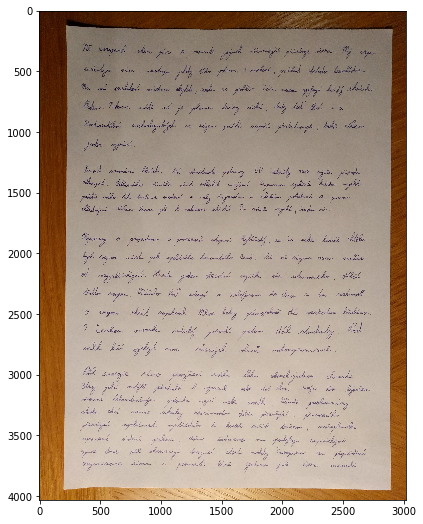

In [4]:
image = cv2.cvtColor(cv2.imread("data/pagedet/%s.jpg" % IMG), cv2.COLOR_BGR2RGB)
implt(image)

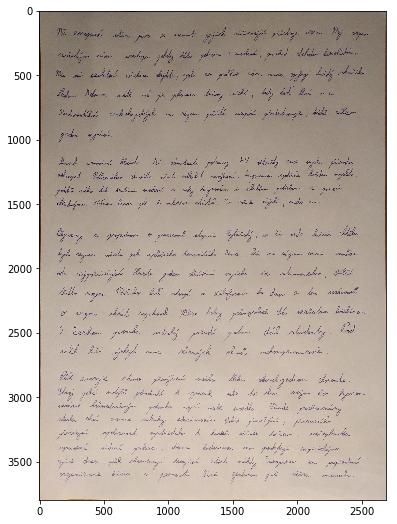

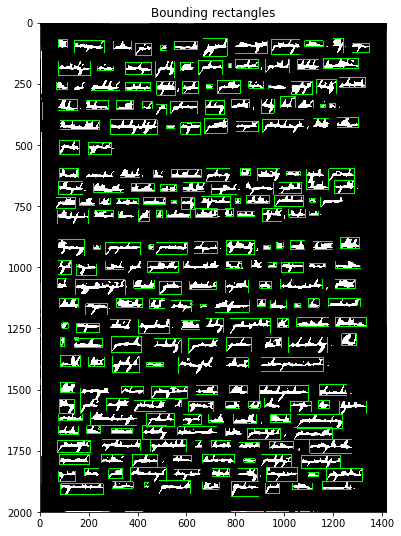

In [5]:
# Crop image and get bounding boxes of words
crop = page.detection(image)
implt(crop)
bBoxes = words.detection(crop)

## Load Trained Model

In [6]:
gapClass = Graph('models/gap-clas/CNN-CG')
charClass = Graph('models/char-clas/en/CharClassifier', operation='y_conv')
print("Successfully loaded.")

INFO:tensorflow:Restoring parameters from models/gap-clas/CNN-CG
INFO:tensorflow:Restoring parameters from models/char-clas/en/CharClassifier
Successfully loaded.


## Applying Model

In [45]:
class Cycler:
    """ Cycle through boxes, separate words """
    height = 60
    step = 2
    
    def __init__(self, image, boxes, idx):
        self.boxes = boxes       # Array of bounding boxes
        self.image = image       # Whole image
        self.index = idx         # Index of current bounding box

        self.nextImg()
    
    def separateWord(self, img):
        """ Separating word into letters """
        implt(img, 'gray')
        
        for x in range(0, 40, 2):
            crop = img[:, 0:10+x]
            char, dim = letterNorm(crop, is_thresh=True, dim=True)
            # TODO Test different values, limit input sizes
            if dim[0] > 4 and dim[1] > 4:
                implt(char, 'gray')
                values = charClass.run([char.flatten()])
#                 print('Raw values', values)
                print('Softmax', x)
                print(self.softmax(values).round(3))
            
    def softmax(self, x):
        """ Compute softmax values for each sets of scores in x """
        return np.exp(x) / np.sum(np.exp(x), axis=1)
            

    def nextImg(self, btn=None):
        """ Getting next image from the array """
        clear_output()
        
        if self.index < len(self.boxes):
            b = self.boxes[self.index]
            x1, y1, x2, y2 = b
            
            # Cuting out the word image and resizing to standard height
            img = resize(self.image[y1:y2, x1:x2], self.height, True)                      
            implt(img, t='Original')  

            self.separateWord(
                imageNorm(
                    img,
                    self.height,
                    border=False,
                    tilt=True,
                    hystNorm=True))

            # Printing index for recovery
            print("Index: " + str(self.index))
            
            # Create button for cycling through images
            bNexi = widgets.Button(description="Next Image")
            bNexi.on_click(self.nextImg)
            display(bNexi)
            
            self.index += 1
            return 0
        else:
            print("END")
            return -1

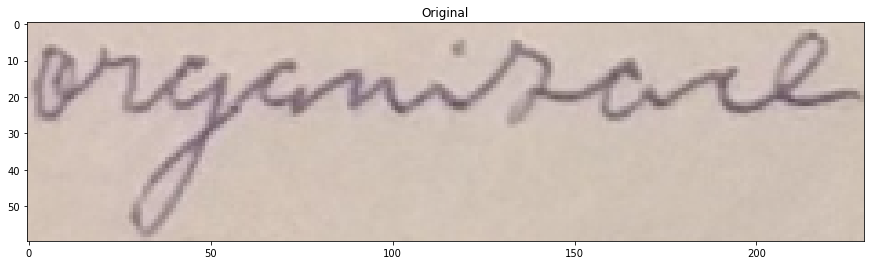

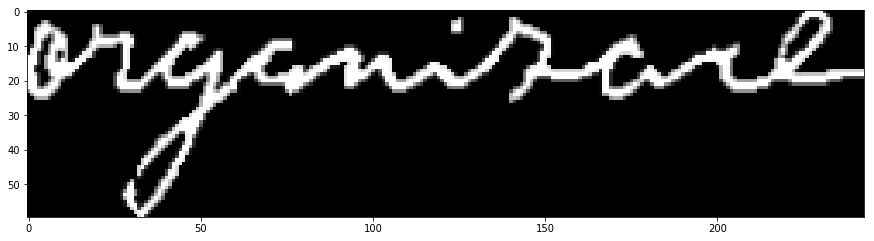

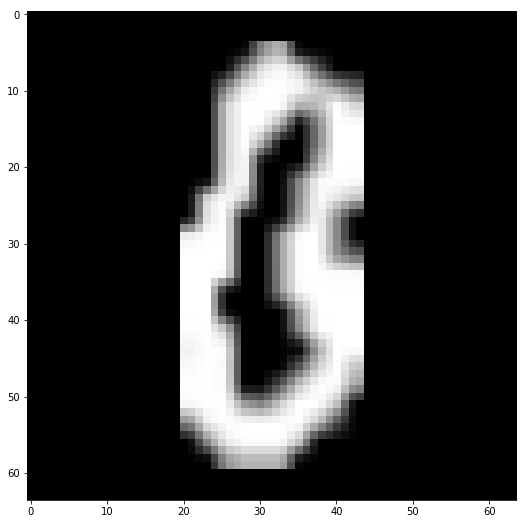

Softmax 0
[[0.    0.001 0.    0.    0.    0.    0.    0.    0.    0.001 0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.002 0.
  0.    0.    0.    0.    0.    0.    0.    0.002 0.    0.    0.    0.
  0.    0.    0.023 0.    0.    0.971 0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.   ]]


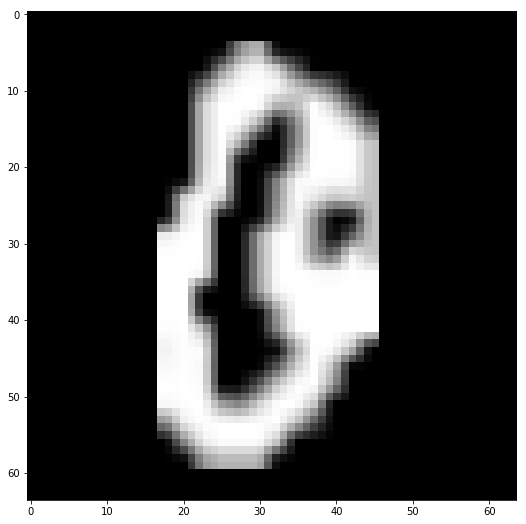

Softmax 2
[[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.002 0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.998 0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.   ]]


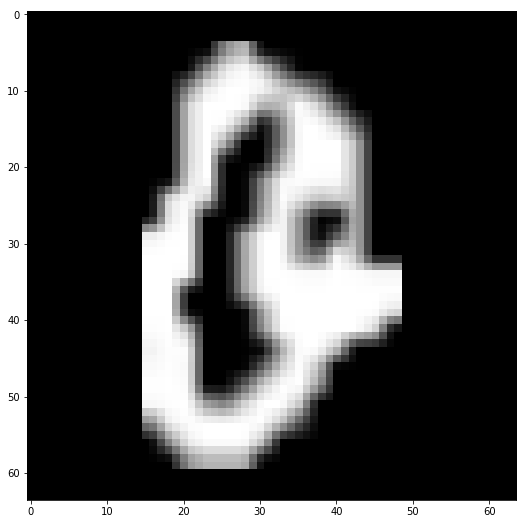

Softmax 4
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0.]]


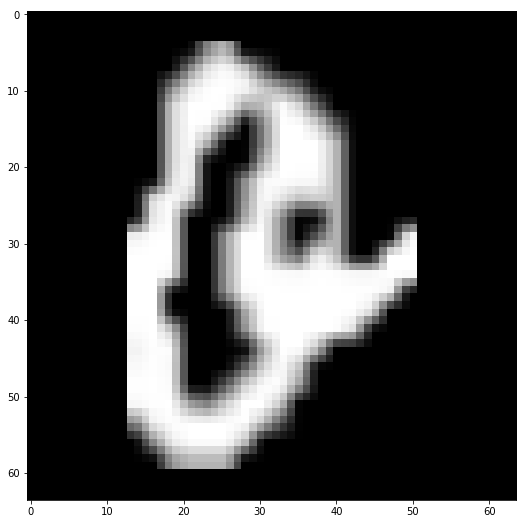

Softmax 6
[[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.001 0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.999 0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.   ]]


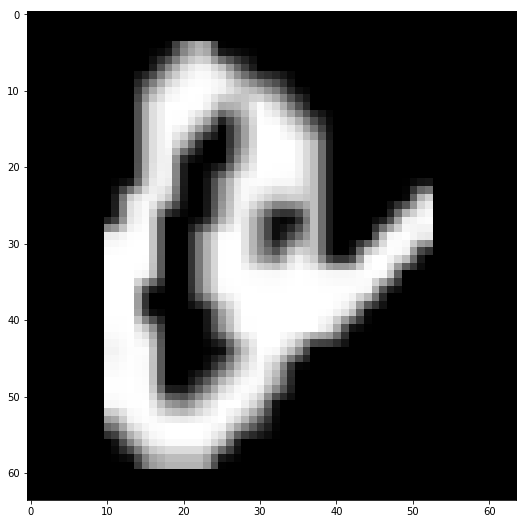

Softmax 8
[[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.005 0.    0.    0.    0.
  0.    0.    0.003 0.    0.    0.992 0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.   ]]


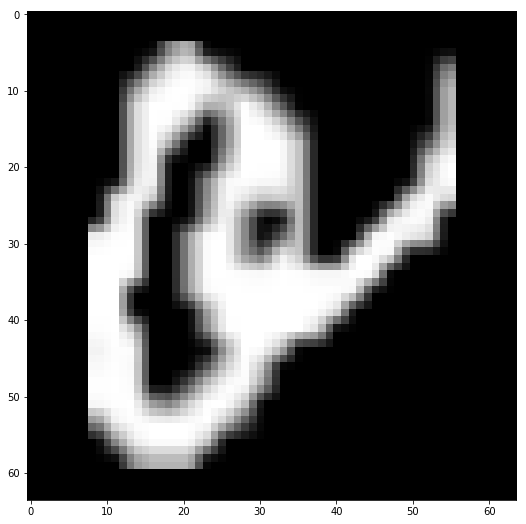

Softmax 10
[[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.087 0.    0.    0.    0.
  0.    0.    0.036 0.    0.    0.876 0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.   ]]


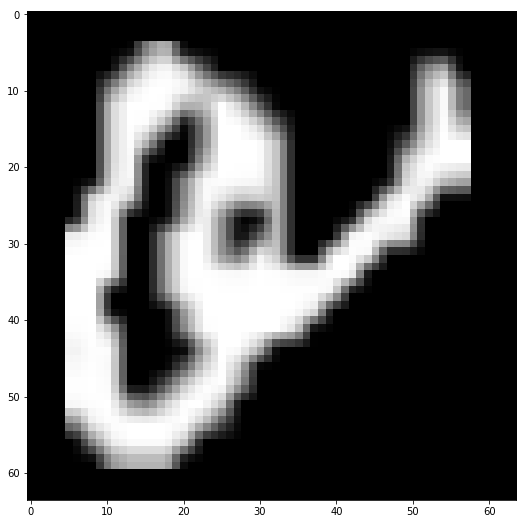

Softmax 12
[[0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.003 0.017 0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.001 0.225 0.    0.    0.01  0.
  0.    0.    0.073 0.    0.    0.66  0.    0.    0.    0.    0.    0.
  0.011 0.    0.    0.001 0.   ]]


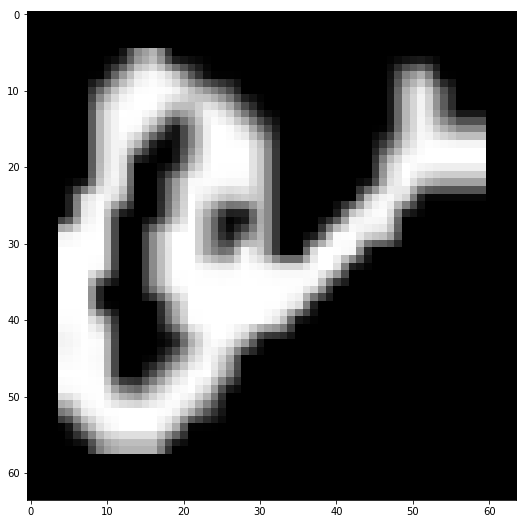

Softmax 14
[[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.004 0.002 0.    0.    0.    0.    0.    0.    0.001
  0.    0.    0.    0.    0.    0.    0.    0.079 0.    0.    0.002 0.
  0.    0.    0.009 0.    0.    0.383 0.001 0.    0.    0.    0.    0.
  0.518 0.    0.    0.001 0.   ]]


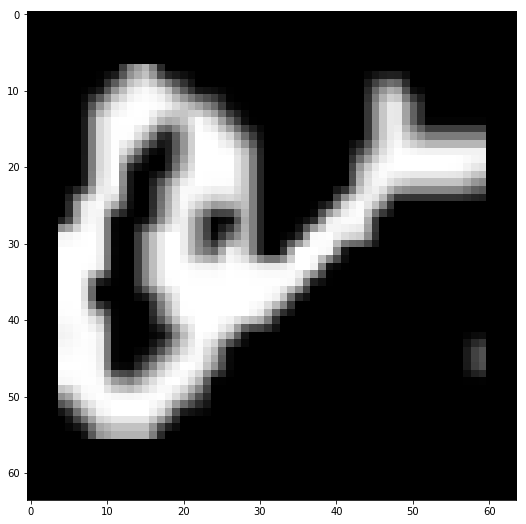

Softmax 16
[[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.002 0.003 0.    0.    0.    0.    0.    0.    0.006
  0.    0.    0.    0.    0.    0.    0.    0.7   0.    0.    0.005 0.
  0.001 0.    0.015 0.    0.    0.015 0.005 0.    0.    0.    0.001 0.
  0.244 0.    0.    0.001 0.   ]]


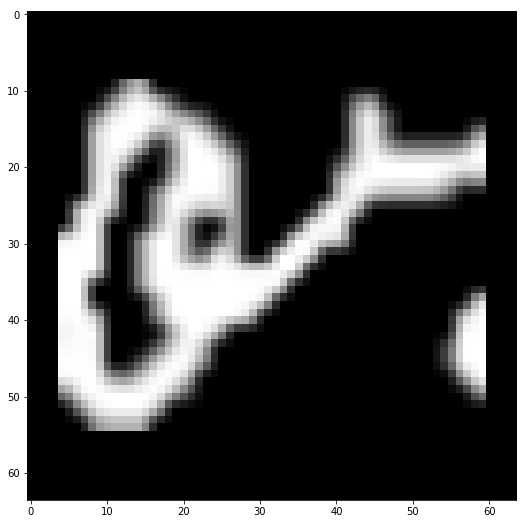

Softmax 18
[[0.003 0.    0.025 0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.002 0.    0.002 0.004 0.    0.    0.    0.    0.    0.    0.079
  0.002 0.    0.    0.    0.    0.    0.    0.833 0.    0.    0.006 0.
  0.    0.    0.    0.    0.    0.    0.001 0.    0.001 0.    0.023 0.004
  0.012 0.    0.    0.003 0.   ]]


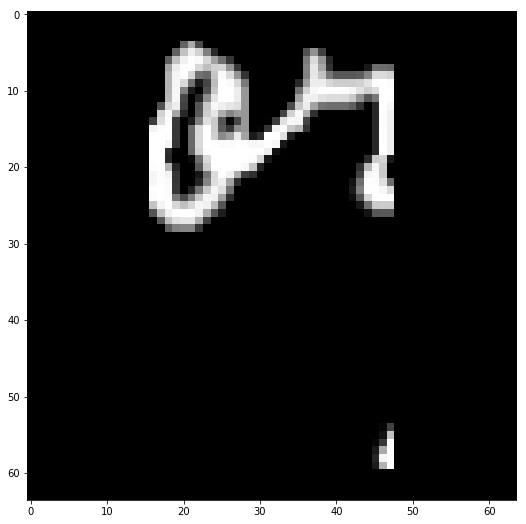

Softmax 20
[[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.001 0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.001 0.    0.    0.    0.    0.997
  0.    0.    0.    0.    0.   ]]


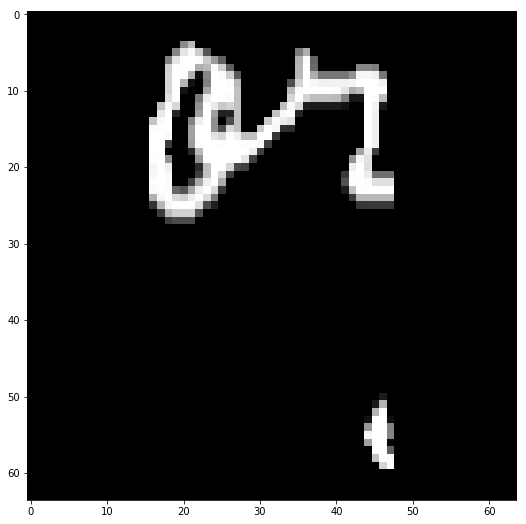

Softmax 22
[[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.001 0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.01  0.    0.    0.986
  0.    0.    0.    0.002 0.   ]]


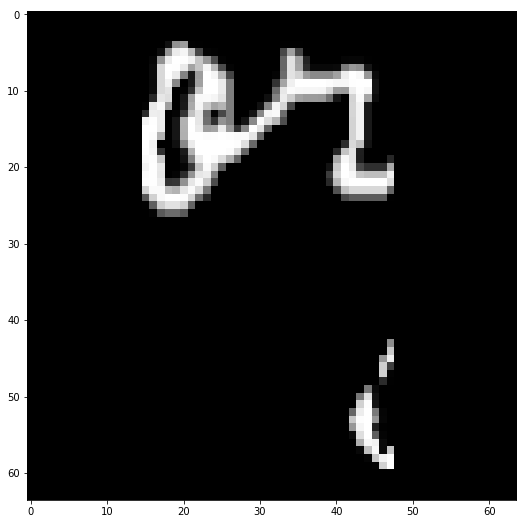

Softmax 24
[[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.001 0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.001 0.    0.    0.    0.127 0.    0.    0.745
  0.    0.    0.    0.125 0.   ]]


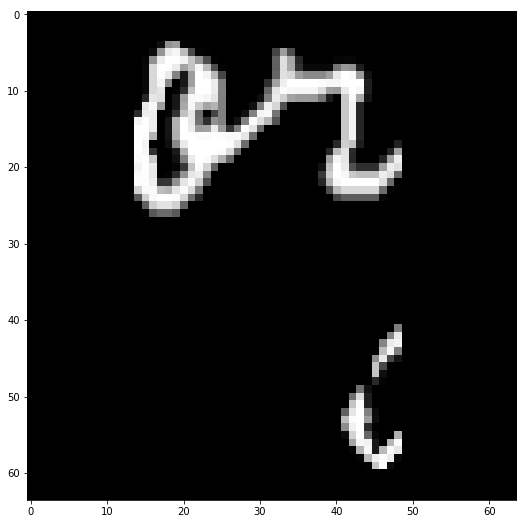

Softmax 26
[[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.009 0.    0.    0.989
  0.    0.    0.    0.001 0.   ]]


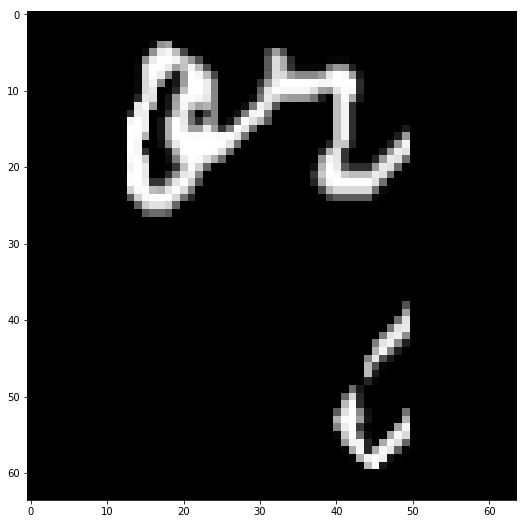

Softmax 28
[[0.    0.    0.    0.    0.    0.    0.    0.    0.003 0.    0.    0.001
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.011 0.    0.    0.984
  0.    0.    0.    0.    0.   ]]


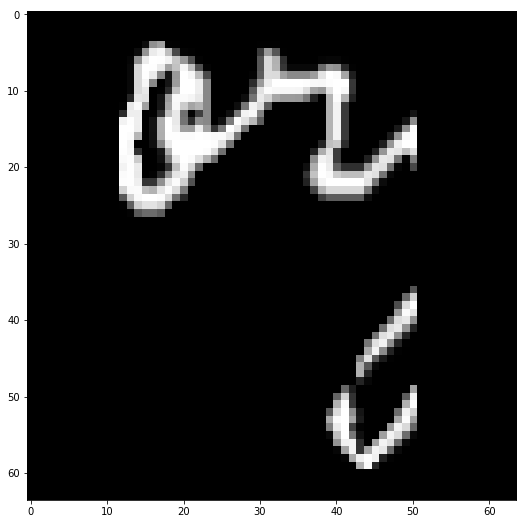

Softmax 30
[[0.    0.    0.    0.    0.    0.    0.    0.    0.05  0.    0.    0.003
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.005 0.
  0.    0.    0.    0.001 0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.001 0.    0.    0.    0.004 0.    0.    0.933
  0.    0.    0.    0.001 0.   ]]


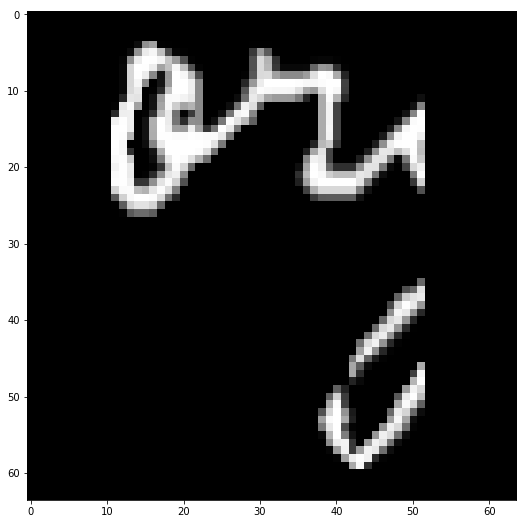

Softmax 32
[[0.    0.    0.    0.    0.    0.    0.    0.    0.001 0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.997
  0.    0.    0.    0.    0.   ]]


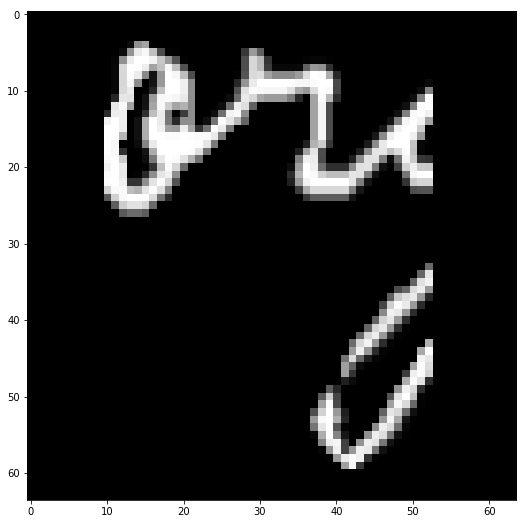

Softmax 34
[[0.    0.    0.    0.    0.    0.    0.    0.    0.001 0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.999
  0.    0.    0.    0.    0.   ]]


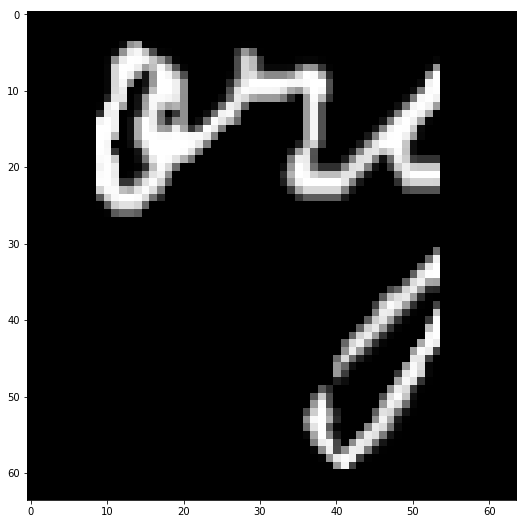

Softmax 36
[[0.    0.    0.    0.    0.    0.    0.    0.    0.001 0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.001 0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.998
  0.    0.    0.    0.    0.   ]]


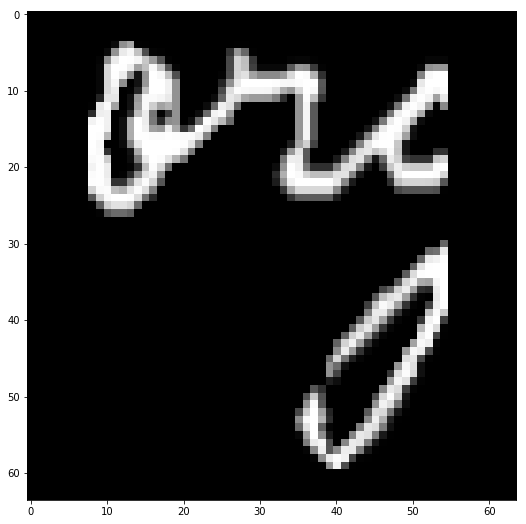

Softmax 38
[[0.    0.    0.    0.    0.    0.    0.    0.    0.003 0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.018 0.006
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.001 0.    0.    0.    0.    0.    0.    0.    0.971
  0.    0.    0.    0.    0.   ]]
Index: 0


Button(description='Next Image', style=ButtonStyle())

In [46]:
# Class cycling through text positions
# Green - Characters
# Red   - Gaps
LAST_INDEX = 0
cycler = Cycler(crop, bBoxes, LAST_INDEX)